# Wrinkled Multilayer abTEM Simulation
This notebook builds a wrinkled multilayer using `utils_bending.py` and runs an abTEM simulation.<br>
Includes the ions and wave variance

In [1]:
import ase
import abtem
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.spacegroup import get_spacegroup
import numpy as np
from scipy.ndimage import center_of_mass as com
import random
import math
from pathlib import Path


In [ ]:
# --- 1. Import Utils or Define Fallbacks ---
try:
    from utils_bending import apply_wrinkle_with_strain, make_monolayer, apply_wrinkle
except ImportError:
    print("Warning: 'utils.py' not found. Defining placeholder functions for demonstration.")
    
    def make_monolayer(W, H, cif_path):
        # Fallback: reads CIF and tiles it
        prim = read(cif_path)
        monolayer = prim * (W, H, 1)
        return monolayer

    def apply_wrinkle_with_strain(coords, wavelength, amplitude, axis="y"):
        # Fallback: Simple sinusoidal wrinkle
        new_coords = coords.copy()
        if axis == "y":
            # Apply wave along Y axis, displace Z
            z_mod = amplitude * np.sin(2 * np.pi * coords[:, 1] / wavelength)
            new_coords[:, 2] += z_mod
        return new_coords
        
    def apply_wrinkle(coords, **kwargs):
        return apply_wrinkle_with_strain(coords, **kwargs)

In [ ]:
# --- 2. Load Base Structure ---
# Update this path if necessary to point to your local file
cif_path = "/Users/danielkh/Documents/Nadja/Na_PHI_model_2/NA_PHI_model_2.cif"

# Create Monolayer
W, H = 12, 12
try:
    PHI_monolayer2 = make_monolayer(W, H, cif_path)
    print(f"Successfully created base monolayer with {len(PHI_monolayer2)} atoms.")
except Exception as e:
    print(f"Error creating monolayer: {e}")
    # Create dummy fallback if file not found
    PHI_monolayer2 = ase.Atoms('C', cell=[10, 10, 10], pbc=True)



In [ ]:
# --- 3. Build 3D Stack (Waves & Rotations) ---

# --- User Controls ---
# Use the monolayer WITH Na+ ions included
monolayer = PHI_monolayer2 

wave = 0
rand_wave = 1 # <-- Set to 1 to use new random logic
rand_amp = 1  # <-- Set to 1 to randomize amplitude as well

rot = 1
rand_rot = 0

# --- Randomization Controls ---
# (0.9, 1.1) means the wavelength/amplitude will be
# randomly varied between 90% and 110% of the base value.
wavelength_factor_range = (0.9, 1.1)
amplitude_factor_range = (0.9, 1.1)
# -----------------------------------

if wave == 1 and rand_wave == 1:
    raise ValueError("Set 'wave=0' to use 'rand_wave=1', or 'rand_wave=0' to use 'wave=1'.")

if rot == 1 and rand_rot == 1:
    raise ValueError("You have both specific and random_rot on.")


## Structure parameters:
# Stacking
layer_spacing = 3.3668
num_layers = 30 # Number of layers to stack

# Waves
try:
    NaPHI_model2_cif = read(cif_path)
    CIF_unitcell = NaPHI_model2_cif.cell[0][0]
except:
    CIF_unitcell = 10.0 # Fallback
    
WL_coeff = 2 # This is now the *base* WL factor
amplitude = 0.5 # This is now the *base* amplitude

# Rotations
if rot == 1:
    rot_ang = 5
elif rot == 0:
    rot_ang = 0

# seed for random number generator
seed = 42
np.random.seed(seed)  # Set the seed for reproducibility

# --- Pre-generate all random factors ---
rand_rotation_angs = np.random.randint(0, 8 + 1, size=num_layers)

wavelength_factors = np.random.uniform(wavelength_factor_range[0], 
                                       wavelength_factor_range[1], 
                                       size=num_layers)

amplitude_factors = np.random.uniform(amplitude_factor_range[0],
                                      amplitude_factor_range[1],
                                      size=num_layers)
# ---------------------------------------


## Initialize the multilayer structure
PHI_multilayer = monolayer.copy()

# --- Apply wave logic to the FIRST layer (layer 0) ---
base_wavelength = CIF_unitcell * WL_coeff
final_wavelength = 0.0
final_amplitude = 0.0

if rand_wave == 1:
    final_wavelength = base_wavelength * wavelength_factors[0] # Use index 0
    if rand_amp == 1:
        final_amplitude = amplitude * amplitude_factors[0] # Use index 0
    else:
        final_amplitude = amplitude
elif wave == 1:
    final_wavelength = base_wavelength
    final_amplitude = amplitude

if final_wavelength > 1e-6: # Check to avoid errors if wavelength is 0
    coords = PHI_multilayer.positions
    wrinkled_coords = apply_wrinkle_with_strain(coords, 
                                                wavelength=final_wavelength, 
                                                amplitude=final_amplitude, 
                                                axis="y")
    PHI_multilayer.positions = wrinkled_coords
# --- End of first layer logic ---


# Stack the remaining monolayers
for layer in range(1, num_layers):
    PHI_nextlayer = monolayer.copy()
    PHI_nextlayer.positions[:, 2] += layer_spacing * layer
    
    # --- Rotation Logic (Unchanged) ---
    if rand_rot == 1:
        PHI_nextlayer.rotate('z', rand_rotation_angs[layer], center="COM")

    if rot == 1:
        if layer > num_layers // 2:
            PHI_nextlayer.rotate('z', rot_ang, center="COM")
    
    # --- Simplified Wave Logic ---
    final_wavelength = 0.0 # Default to 0
    final_amplitude = 0.0  # Default to 0
    
    if rand_wave == 1:
        # Get the pre-generated random factor for this layer
        final_wavelength = base_wavelength * wavelength_factors[layer]
        
        if rand_amp == 1:
            final_amplitude = amplitude * amplitude_factors[layer]
        else:
            final_amplitude = amplitude # Use fixed base amplitude
    
    elif wave == 1:
        # Use the fixed, non-random values
        final_wavelength = base_wavelength
        final_amplitude = amplitude
    
    # --- End of new wave logic ---

    # Apply the waves on the monolayer
    if final_wavelength > 1e-6: # Only apply if wave is active
        coords = PHI_nextlayer.positions
        wrinkled_coords = apply_wrinkle_with_strain(coords, final_wavelength, final_amplitude, axis="y")
        PHI_nextlayer.positions = wrinkled_coords
    
    PHI_multilayer += PHI_nextlayer


PHI_multilayer.cell = [0, 0, 0]

print(f"Stack building complete. 'PHI_multilayer' is ready.")
print(f"Total atoms in stack: {len(PHI_multilayer)}")




In [ ]:
# --- 4. Post-Processing: Na Removal & Jitter ---

# --- Controls for final structure ---
final_na_occupancy = 0.5 
na_removal_seed = 42

# Jitter controls
na_xy_jitter_A = 0.75 # e.g., 0.75A in-plane
na_z_jitter_A  = 1.5  # e.g., 1.5A out-of-plane
# ----------------------------------------

# Initialize generators
random.seed(na_removal_seed)
rng = np.random.default_rng(na_removal_seed)

print(f"Stack building complete. Total atoms before removal: {len(PHI_multilayer)}")

# --- Randomly remove Na+ from the final 3D stack ---

# 1. Separate Na and other atoms
other_atoms = [atom for atom in PHI_multilayer if atom.symbol != 'Na']
na_atoms = [atom for atom in PHI_multilayer if atom.symbol == 'Na']

# 2. Calculate how many Na atoms to keep
num_na_to_keep = int(round(len(na_atoms) * final_na_occupancy))
print(f"Total Na sites in 3D stack: {len(na_atoms)}")
print(f"Target Na occupancy: {final_na_occupancy}")
print(f"Randomly keeping {num_na_to_keep} Na atoms.")

# 3. Randomly select the Na atoms to keep
na_atoms_to_keep_list = random.sample(na_atoms, num_na_to_keep)

# --- Apply Jitter to the selected Na+ ions ---
if num_na_to_keep > 0:
    # Convert list to Atoms object to access positions easily
    na_atoms_to_keep = ase.Atoms(na_atoms_to_keep_list)
    
    # Generate random jitter arrays
    xy_jitters = rng.uniform(-na_xy_jitter_A, na_xy_jitter_A, size=(num_na_to_keep, 2))
    z_jitters = rng.uniform(-na_z_jitter_A, na_z_jitter_A, size=num_na_to_keep)
    
    # Apply jitter
    na_atoms_to_keep.positions[:, :2] += xy_jitters
    na_atoms_to_keep.positions[:, 2] += z_jitters
    
    print(f"Applied random XYZ jitter to {num_na_to_keep} Na atoms.")
    
    # 4. Create the final Atoms object
    final_structure_with_partial_Na = ase.Atoms(other_atoms) + na_atoms_to_keep

else:
    print("No Na atoms were kept.")
    final_structure_with_partial_Na = ase.Atoms(other_atoms)
# --------------------------------------------

# 5. Assign the original cell and PBC
final_structure_with_partial_Na.cell = PHI_multilayer.cell

print(f"New total atoms in final structure: {len(final_structure_with_partial_Na)}")

# --- Save (Optional) ---
output_filename = "PHI_multilayer_partial_Na_jittered.cif" 
write(output_filename, final_structure_with_partial_Na)
print(f"Saved to {output_filename}")


# --- 5. Final Structure & Simulation Setup ---


print("Structure ready for potential generation.")



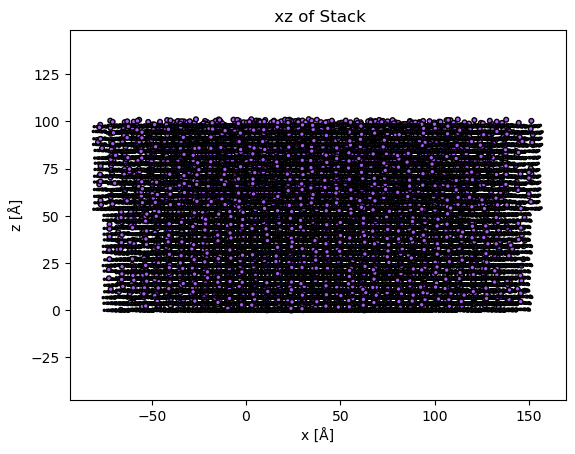

In [10]:
# Example Visualization 
view = 'xz'
abtem.show_atoms(final_structure_with_partial_Na,f'{view}', title=f" {view} of Stack")
plt.show()

In [11]:
# === abTEM Simulation ===
import abtem

# Optional: rotate and center structure
angle = 90  # in degrees
structure = final_structure_with_partial_Na.copy()
structure.rotate('y', angle, center="COM")
structure.center(vacuum=100)

# Optional: Frozen phonons (commented out)
# frozen_phonons = abtem.FrozenPhonons(structure, 10, sigmas=0.5)

# Create potential
potential = abtem.Potential(
    structure,  # or frozen_phonons
    gpts=1024,
    projection="finite",
    slice_thickness=1,
    periodic=True,
)

# Create probe and match grid
wave = abtem.Probe(energy=200e3, semiangle_cutoff=0.2)
wave.grid.match(potential)

# Run multislice simulation and compute diffraction
measurement = wave.multislice(potential).diffraction_patterns(max_angle=30)
Diffraction_multilayer = measurement.compute()



[########################################] | 100% Completed | 66.86 ss


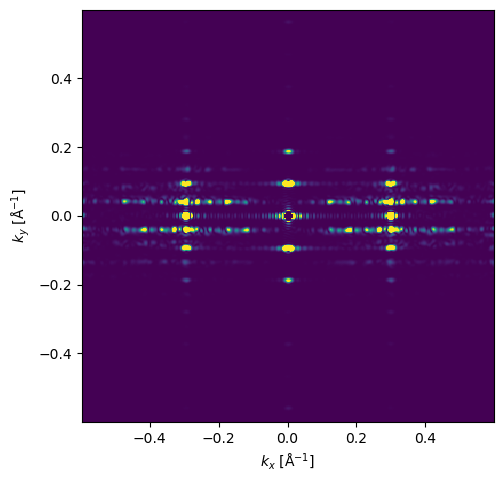

In [13]:
Diffraction_multilayer.block_direct().crop(15).show(vmax=1e-4)